In [1]:
import h5py
import os
import numpy as np
import pandas as pd
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm, Normalize, ListedColormap, rgb2hex, LinearSegmentedColormap
from matplotlib.cm import get_cmap
from matplotlib.ticker import ScalarFormatter, FuncFormatter, FixedLocator
from matplotlib.font_manager import FontProperties
import matplotlib.tri as tri
from matplotlib.collections import LineCollection
from scipy.spatial import KDTree, ConvexHull
from scipy.interpolate import make_interp_spline
from scipy.stats import pearsonr, spearmanr
import fipy as fp
from fipy.viewers.matplotlibViewer.matplotlib2DContourViewer import Matplotlib2DContourViewer
import gmsh
import re
import timeit
from tqdm import tqdm
import moviepy.editor as mp

In [2]:
path='/home/artem.kays/scripts/lncRNAeffects/RNA_diffusion'
os.chdir(path)
from utils.free_energy import *
from utils.graphics_3d import *
from utils.input_parse import *
from utils.mesh_generation import *
from utils.utils import *
from utils.write_files import *

In [3]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.rcParams['font.size']=18

### Stuff on 2D mesh w/o chromatin

In [4]:
nx, dx = 60, 0.5
radius=float(nx)*dx/2
cellSize=dx*1.5
mesh = fp.Gmsh2D('''
                     cellSize = %g;
                     radius = %g;
                     Point(1) = {0, 0, 0, cellSize};
                     Point(2) = {-radius, 0, 0, cellSize};
                     Point(3) = {0, radius, 0, cellSize};
                     Point(4) = {radius, 0, 0, cellSize};
                     Point(5) = {0, -radius, 0, cellSize};
                     Circle(6) = {2, 1, 3};


                    Circle(7) = {3, 1, 4};
                    Circle(8) = {4, 1, 5};
                    Circle(9) = {5, 1, 2};
                    Line Loop(10) = {6, 7, 8, 9};
                    Plane Surface(11) = {10};

       '''%(cellSize,radius))

In [18]:
bin_r = np.array([[0, 0], [1, 0], [1, 1], [2, 1], [2, 2], [3, 2], [3, 3]])
bin_r = np.asarray([(5*np.cos(2*np.pi/9*x), 5*np.sin(2*np.pi/9*x)) for x in range(9)])
np.random.seed(1)
#bin_r = np.random.normal(0, .5, size=(len(bin_r), 2)) + bin_r

In [19]:
input_parameters = input_parse('input/input_params_diffusion.txt')
d_chr = fp.CellVariable(mesh=mesh, name=r'$d_{chr}$', hasOld=False, value = dist_to_polygonal_chain_naive(np.c_[*mesh.cellCenters], bin_r))
d_chr_face = fp.FaceVariable(mesh=mesh, name=r'$d_{chr}$', value = dist_to_polygonal_chain_naive(np.c_[*mesh.faceCenters], bin_r))
FE = free_energy_RNA_Chrom_FH(
                 NP=input_parameters['NP'], 
                 NR=input_parameters['NR'], 
                 NM=input_parameters['NM'], 
                 chi_p=input_parameters['chi_p'],
                 chi_pr=input_parameters['chi_pr'], 
                 chi_r=input_parameters['chi_r'],
                 c_LJ = input_parameters['c_LJ'],
                 sigma_LJ = input_parameters['sigma_LJ'],
                 c_DH = input_parameters['c_DH'],
                 sigma_DH = input_parameters['sigma_DH'])
specific_LJ = FE.specific_LJ(mesh, d_chr)
specific_DH = FE.specific_DH(mesh, d_chr)
rna_chrom_fe = fp.CellVariable(mesh=mesh, name=r'$\underline{U_{LJ}}[d_{chr}] + \underline{U_{DH}}[d_{chr}]$', value = specific_LJ + specific_DH)

In [10]:
output_dir='results/sim_chrom_2D/no_lj_c_LJ_0.2_sigma_LJ_0.5_c_DH_0.5_sigma_DH_2.0_chi_pr_0.0/'
plot_spatial_variables(mesh=mesh, spatial_variable=rna_chrom_fe, variable_name='LJ+DH',
                       colormap="coolwarm", output_dir=output_dir, val_lim=[-0.8,0.8], bin_r=bin_r)

In [20]:
chr_mask = (d_chr < input_parameters['sigma_LJ'])
chr_mask_2 = (d_chr < input_parameters['sigma_LJ'] + input_parameters['no_phi_0_dist'])
phi_p = fp.CellVariable(mesh=mesh, name=r'$\phi_{prot}$', hasOld=True, value = input_parameters['phi_p_0'] * ~chr_mask_2)
phi_r = fp.CellVariable(mesh=mesh, name=r'$\phi_{lncRNA}$', hasOld=True, value = input_parameters['phi_r_0'] * ~chr_mask_2)

In [54]:
type(specific_LJ_face)

fipy.variables.faceVariable.FaceVariable

In [21]:
chr_mask_face = (d_chr_face < input_parameters['sigma_LJ'])
largeValue=1e6
Gamma=2
gradient = fp.FaceVariable(mesh=mesh, value=0, rank=1)
eqn = (fp.TransientTerm() == fp.DiffusionTerm(coeff=Gamma) + \
       fp.DiffusionTerm(coeff=specific_LJ * chr_mask_face) - \
       fp.ImplicitSourceTerm((chr_mask_face * specific_LJ * gradient * mesh.faceNormals).divergence))

TypeError: unsupported operand type(s) for *: 'CellVariable' and 'binOp'

In [35]:
largeValue=max(specific_LJ_face)
largeValue

np.float64(6.7531725533343375e+28)

In [22]:
D_protein = float(input_parameters['D_protein'])
D_rna = float(input_parameters['D_rna'])

In [28]:
specific_LJ_face = FE.specific_LJ_faces(mesh, d_chr_face)

In [37]:
eqn0 = (fp.TransientTerm(coeff=1.,var=phi_p) == fp.DiffusionTerm(coeff=D_protein*FE.dmu_p_dphi_p(phi_p,phi_r), var=phi_p) + \
        fp.DiffusionTerm(coeff=D_protein*FE.dmu_p_dphi_r(phi_p,phi_r), var=phi_r) + \
        fp.DiffusionTerm(coeff=largeValue * chr_mask_face,var=phi_p) - \
        fp.ImplicitSourceTerm(coeff=((chr_mask_face * largeValue * gradient * mesh.faceNormals).divergence),var=phi_p)) \
        # + fp.PowerLawConvectionTerm(coeff=D_protein*specific_LJ.grad, var=phi_p) \
        # - fp.ImplicitSourceTerm(specific_LJ * mask) + specific_LJ * mask * 0

In [48]:
fp.DiffusionTerm(coeff=phi_p.grad)

DiffusionTerm(coeff=[$\phi_{prot}$_gauss_grad])

In [42]:
(chr_mask_face * largeValue * gradient * mesh.faceNormals)[0][chr_mask_face].value

array([-0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,  0., -0.,
        0.,  0., -0.,  0., -0.,  0., -0.,  0.,  0., -0.,  0., -0., -0.,
       -0.,  0., -0., -0.,  0., -0.,  0., -0., -0., -0., -0., -0., -0.,
        0., -0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0., -0., -0.,  0.,
       -0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0., -0., -0.,  0.,  0.,
        0., -0.,  0.,  0., -0., -0., -0.,  0., -0.,  0., -0.,  0.,  0.,
        0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,
        0.,  0., -0.,  0.,  0., -0., -0., -0.,  0., -0., -0., -0.,  0.,
       -0.,  0., -0.,  0., -0., -0., -0.,  0., -0., -0.,  0., -0.,  0.,
        0., -0., -0., -0.,  0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0., -0.,  0., -0.,  0.,
       -0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0., -0., -0.,  0.,  0.,
        0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.])

In [53]:
d_chr.value

array([0., 0., 0., ..., 0., 0., 0.])

In [52]:
d_ch=d_chr.value
d_ch[d_ch>1]=0
d_ch

array([0., 0., 0., ..., 0., 0., 0.])

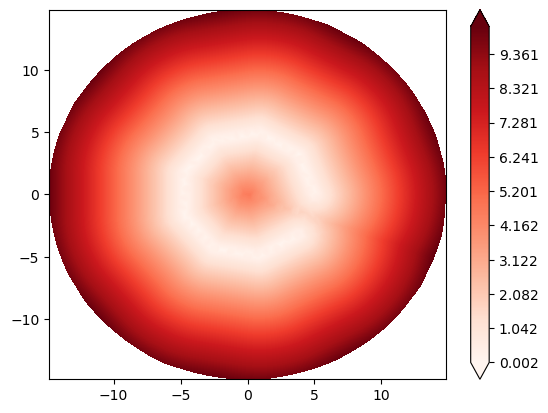

In [495]:
d_chr = fp.CellVariable(mesh=mesh, value=dist_to_polygonal_chain_naive(np.c_[*mesh.cellCenters], bin_r))
phi = fp.CellVariable(mesh=mesh, value=d_chr)
#phi[(d_chr>5) & (d_chr<6)]=np.nan
phi[d_chr<2]=-np.inf
phi[d_chr>7]=np.inf

min_val, max_val = phi[np.isfinite(phi)].min(), phi[np.isfinite(phi)].max()
phi[phi==-np.inf] = min_val
phi[phi==np.inf] = max_val

# create masked triangles
triang = tri.Triangulation(mesh.x.value, mesh.y.value)
triang.set_mask(np.any(np.isnan(phi.value)[triang.triangles], axis=1))

#viewer = fp.Matplotlib2DViewer(vars=d_chr, colorbar=0, cmap='Reds')
#viewer.plotMesh()
fig, ax = plt.subplots()
#if not (np.isnan(df[i]).any() or np.isfinite(df[i]).any()):
cs = ax.tricontourf(triang,
                    d_chr,
                    levels=np.linspace(d_chr.min(), d_chr.max(), 256),
                    cmap="Reds",
                    extend="both")
fig.colorbar(cs)

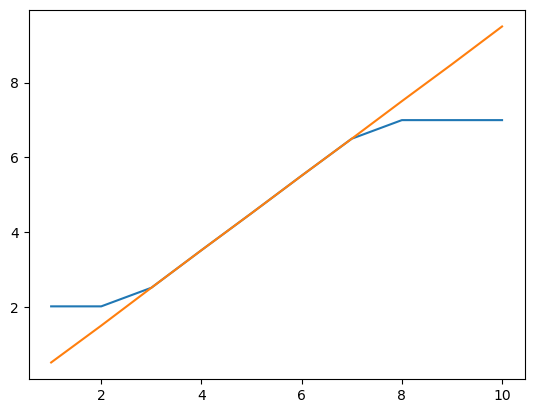

In [510]:
def sum_in_domain(mesh, var, chr_mask):
    sum_ = np.sum(mesh.cellVolumes[~chr_mask]*var.value[~chr_mask])
    return sum_


def av_in_domain(mesh, var, chr_mask):
    av = np.sum(mesh.cellVolumes[~chr_mask]*var.value[~chr_mask])/np.sum(mesh.cellVolumes[~chr_mask])
    return av

av_p = [av_in_domain(mesh, phi, ~((d_chr<d) & (d_chr>d-1))) for d in range(1, 11)]
av_d = [av_in_domain(mesh, d_chr, ~((d_chr<d) & (d_chr>d-1))) for d in range(1, 11)]
fig, ax = plt.subplots()
ax.plot(range(1, 11), av)
ax.plot(range(1, 11), av_d)

In [504]:
phi.cellVolumeAverage.value

np.float64(5.0459140488595)

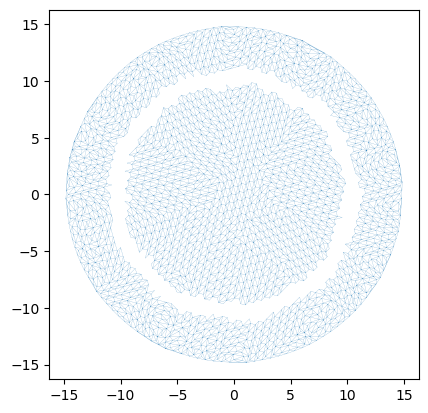

In [163]:
fig, ax = plt.subplots()
ax.triplot(triang, lw=0.1)
ax.set_aspect('equal', adjustable='box')

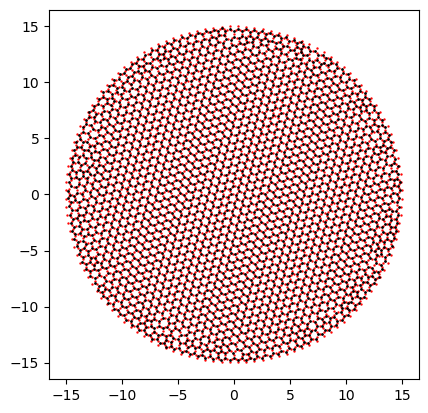

In [242]:
fig, ax = plt.subplots()
ax.scatter(*mesh.faceCenters, s=0.5, c='r')
ax.scatter(*mesh.cellCenters, s=1, c='black')
ax.set_aspect('equal', adjustable='box')

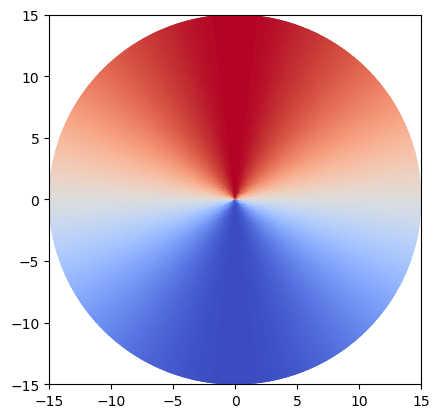

In [50]:
phi = fp.CellVariable(name = "solution variable",
                   mesh = mesh,
                   value = [mesh.cellCenters.value[1][i] / (mesh.cellCenters.value[0][i]**2+ mesh.cellCenters.value[1][i]**2)**0.5
                            for i in range(len(mesh.cellCenters.value[0]))])

viewer = fp.Matplotlib2DViewer(vars=phi, colorbar=0, cmap='coolwarm')
viewer.plotMesh()

### Stuff on 2D mesh with chromatin

#### Mesh generation

In [21]:
!cat a.geo | grep -v -e ^'//' -v -e '^[[:space:]]*$' > b.geo

In [58]:
!python3 scripts/gmsh-master-tutorials-python/x1.py -nopopup

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 40%] Meshing curve 2 (Line)
Info    : [ 70%] Meshing curve 3 (Circle)
Info    : Done meshing 1D (Wall 0.000290393s, CPU 0.000219s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Cone, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0696489s, CPU 0.010616s)
Info    : Meshing 3D...
Info    : 3D Meshing 1 volume with 1 connected component
Info    : Tetrahedrizing 181 nodes...
Info    : Done tetrahedrizing 189 nodes (Wall 0.00184138s, CPU 0.001537s)
Info    : Reconstructing mesh...
Info    :  - Creating surface mesh
Info    :  - Identifying boundary edges
Info    :  - Recovering boundary
Info    : Done reconstructing mesh (Wall 0.00417442s, CPU 0.001682s)
Info    : Found volume 1
Info    : It. 0 - 0 nodes created - worst tet radius 2.42343 (nodes removed 0 0)
Info    : 3D refi

In [696]:
radius = 15
scale=5
n_cells=2500
sigma_chr = input_parameters['sigma_chr']
bin_r = np.asarray([(5*np.cos(2*np.pi/9*x), 5*np.sin(2*np.pi/9*x)) for x in range(9)])
#chrom_2d(bin_r, radius, sigma_LJ, n_cells, scale, path)
mesh = fp.Gmsh2D('results/hollow_chrom_2D/mesh_n_cells_2500.0_scale_5.0_sigma_chr_0.5.msh2')
mesh.cellCenters.shape

(2, 7046)

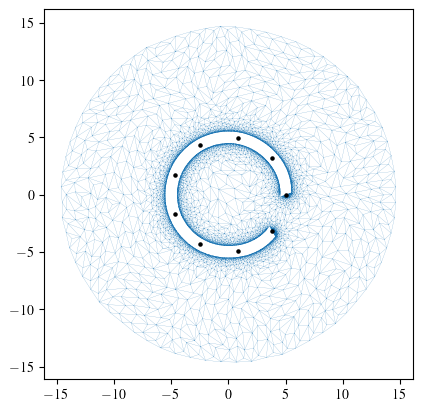

In [705]:
mode_cells = 1
if mode_cells:
    mask=np.any(mesh.exteriorFaces.value[mesh.cellFaceIDs.data], axis=0)
    #mask2=(mesh.x.value<1.25)&(mesh.z.value>=0)&(mesh.z.value<0.1)
    triang = tri.Triangulation(mesh.x.value, mesh.y.value)
    triang.set_mask(np.all(mask[triang.triangles], axis=1))
else:
    triang = tri.Triangulation(mesh.faceCenters.value[0], mesh.faceCenters.value[1])
    triang.set_mask(np.all(mesh.exteriorFaces.value[triang.triangles], axis=1))

fig, ax = plt.subplots()
ax.triplot(triang, lw=0.1)
#ax.scatter(*mesh.cellCenters, s=0.5, c='black')
#ax.scatter(*mesh.faceCenters, s=0.5, c='r')
plt.scatter(bin_r[:, 0], bin_r[:, 1], c='black', edgecolor='k', s=5)
ax.set_aspect('equal', adjustable='box')
fig.savefig(fname=f'{path}/figures/sandbox/abab.png', dpi=300, format='png')

In [961]:
ext_faces=mesh.faceCenters.value.T[mesh.exteriorFaces]
chrom_faces=ext_faces[ext_faces[:,0]**2+ext_faces[:,1]**2<(main_radius/1.1)**2]
d_chr = KDTree(chrom_faces).query(mesh.cellCenters.value.T)[0]+sigma_LJ
d_chr = fp.CellVariable(mesh=mesh, name=r'$d_{chr}$', value = d_chr)
d_chr_face = KDTree(chrom_faces).query(mesh.faceCenters.value.T)[0]+sigma_LJ
d_chr_face = fp.FaceVariable(mesh=mesh, name=r'$d_{chr\_face}$', value = d_chr_face)
d_chr_sur = fp.CellVariable(mesh=mesh, name=r'$d_{chr}$', value = d_chr - sigma_chr)

In [1010]:
dist_f = 'results/hollow_chrom_2D/dist_n_cells_2500.0_scale_5.0_sigma_chr_0.5.hdf5'
if not os.path.exists(dist_f):
    with h5py.File(dist_f, 'a') as f:
        f.create_dataset("d_chr", (len(d_chr)))
        f.create_dataset("d_bin", (len(bin_r), len(d_chr)))
        f["d_chr"][:] = d_chr.value
        for bin_ in range(len(bin_r)):
            f["d_bin"][bin_,:] = norm(mesh.cellCenters.value.T - bin_r[bin_], axis=1)

#### Diffusion simulation

In [946]:
input_parameters = input_parse('input/input_params_diffusion.txt')
phi_p = fp.CellVariable(mesh=mesh, name=r'$\phi_{prot}$',
                        value = input_parameters['phi_p_0'] * ((mesh.x.value-bin_r[2][0])**2 + (mesh.y.value-bin_r[2][1])**2<1))
DH=fp.FaceVariable(mesh = mesh, name = r'$\underline{U_{DH}}[d_{chr}]$', value=-0.5/d_chr_face * np.exp(-d_chr_face/2))

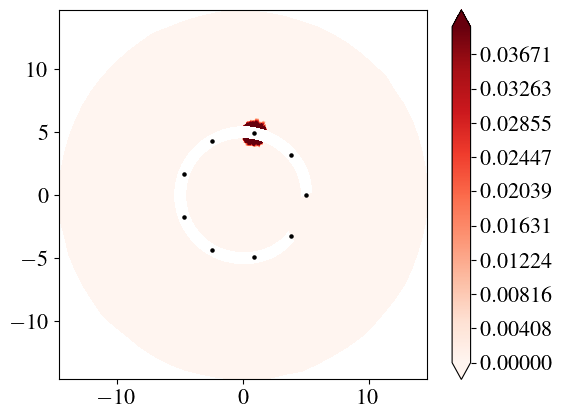

In [947]:
sp_var = phi_p

fig, ax = plt.subplots()
cs = ax.tricontourf(triang,
                    sp_var,
                    levels=np.linspace(sp_var.min(), sp_var.max(), 256),
                    cmap="Reds",
                    extend="both")
fig.colorbar(cs)
plt.scatter(bin_r[:, 0], bin_r[:, 1], c='black', edgecolor='k', s=5)
ax.set_aspect('equal', adjustable='box')
fig.savefig(fname=f'{path}/figures/sandbox/abob.png', bbox_inches='tight', dpi=300, format='png')

In [948]:
eqn = (fp.TransientTerm(var=phi_p) == fp.DiffusionTerm(coeff=10, var=phi_p))
for i in range(60):
    eqn.sweep(dt=0.05)

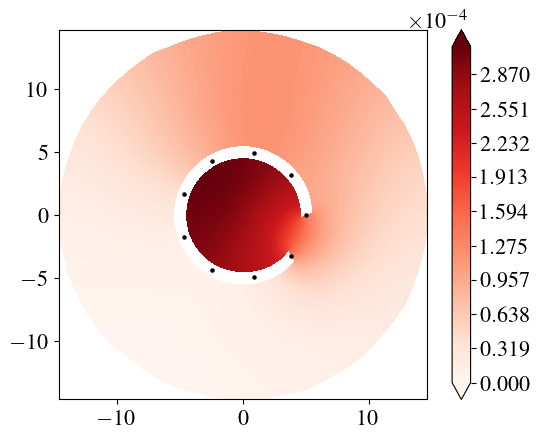

In [949]:
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16

fig, ax = plt.subplots()
cs = ax.tricontourf(triang,
                    phi_p,
                    levels=np.linspace(0, phi_p.max(), 256),
                    cmap="Reds",
                    extend="both")
cbar=fig.colorbar(cs)
cbar.formatter.set_powerlimits((0, 0))
plt.scatter(bin_r[:, 0], bin_r[:, 1], c='black', edgecolor='k', s=5)
ax.set_aspect('equal', adjustable='box')
fig.savefig(fname=f'{path}/figures/sandbox/boba.png', bbox_inches='tight', dpi=300, format='png')

#### Analysis

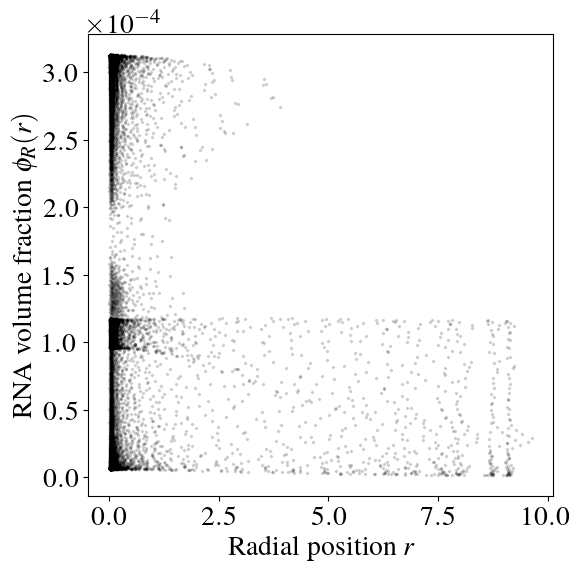

In [998]:
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20

plt.rcParams['font.size']=20
fig, axs = plt.subplots(1,1,figsize=(6,6))
for i in range(int(max(d_chr))):
    axs.scatter(d_chr_sur, phi_p, s=10, alpha=0.01, c='black', marker='.')

axs.set_ylabel(r'RNA volume fraction $\phi_R(r)$')
axs.set_xlabel(r'Radial position $r$')
axs.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fig.savefig(f'{path}/figures/sandbox/baob.png', bbox_inches='tight', dpi=300, format='png')

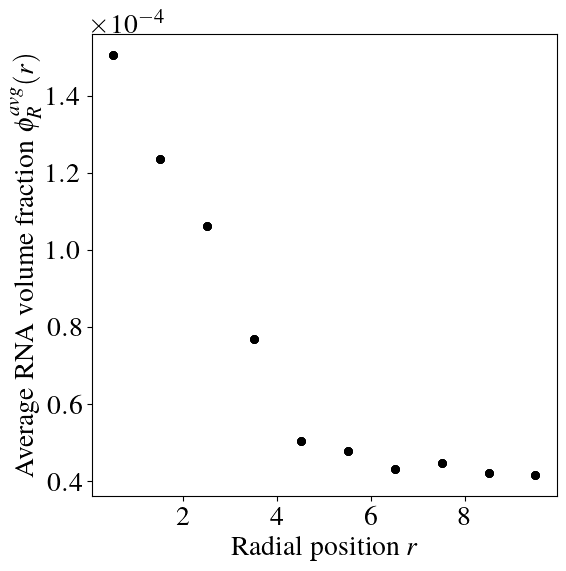

In [999]:
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20

sigma_DH = input_parameters['sigma_DH']
d_max=int(max(d_chr_sur))
l=[av_in_domain(mesh, phi_p, (i<=d_chr_sur)&(d_chr_sur<i+1)) for i in np.linspace(0, d_max, d_max+1)]

plt.rcParams['font.size']=20
fig, axs = plt.subplots(1,1,figsize=(6,6))
for i in range(int(max(d_chr))):
    axs.scatter(np.linspace(0, d_max, d_max+1)+0.5,
                l, s=100, c='black', marker='.')

axs.set_ylabel(r'Average RNA volume fraction $\phi^{avg}_R(r)$')
axs.set_xlabel(r'Radial position $r$')
axs.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fig.savefig(f'{path}/figures/sandbox/abob.png', bbox_inches='tight', dpi=300, format='png')

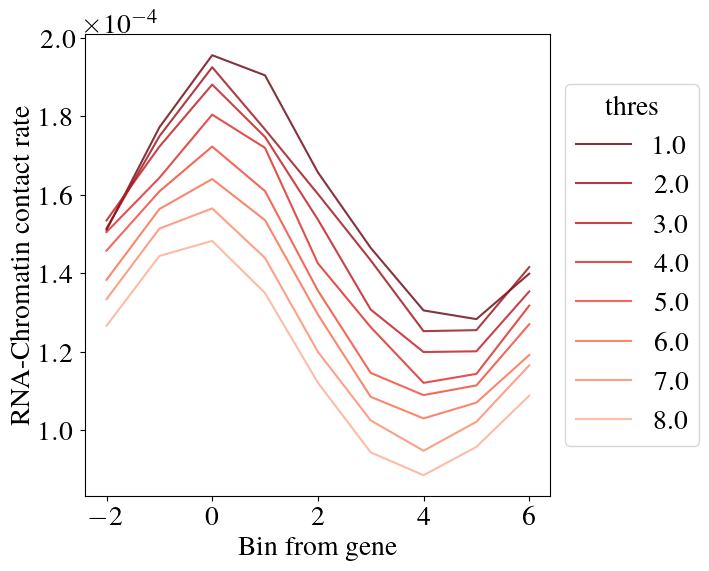

In [1004]:
gene_bin = 2
rnachrom_thress = np.linspace(1,8,8)
cmap = plt.get_cmap('Reds_r')
color_vals = np.linspace(0.0,0.7,len(rnachrom_thress))

plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20

fig,axs = plt.subplots(1,1,figsize=(6,6))
with h5py.File(dist_f, 'r') as f:
    for i, thres in enumerate(rnachrom_thress):
        l=[av_in_domain(mesh, phi_p, (f['d_bin'][bin_, :]<=thres+0.5)) for bin_ in range(f['d_bin'].shape[0])]
        axs.plot(np.arange(f['d_bin'].shape[0]) - gene_bin,
                    l, 
                    label=str(thres),
                    alpha=0.8, color = cmap(color_vals[i]))
            
axs.set_ylabel(r'RNA-Chromatin contact rate')
axs.set_xlabel(r'Bin from gene')
axs.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axs.legend(title="thres", loc='right', bbox_to_anchor=(1.35, 0.5))
plt.savefig(f'{path}/figures/sandbox/boab.png', bbox_inches='tight', dpi=300, format="png")

### Stuff on 3D mesh with real chromatin

In [4]:
# chrom_f = 'GSE184270_GM12878_chr4_1000000_ss_10.pdb'
chrom_f = 'GSM5851256_MCF7_Rep1/50000_chr11_60000000_70000000.pdb'
names = ['ATOM', 'num', 'type', 'alt_loc', 'aa', 'chain', 'seq_num', 'res_insert',
         'x', 'y', 'z', 'occupancy', 'tempfactor', 'seg_id', 'elt_symb', 'charge']
colspecs = [(0, 4), (6, 11), (12, 16), (16, 17), (17, 20), (21, 22), (22, 26),
            (26, 27), (30, 38), (38, 46), (46, 54), (54, 60), (60, 66), (72, 76),
            (76, 78), (78, 80)]
chrom_pdb = pd.read_fwf(f'{path}/data/{chrom_f}', names=names, colspecs=colspecs)\
              .query('ATOM=="ATOM"')

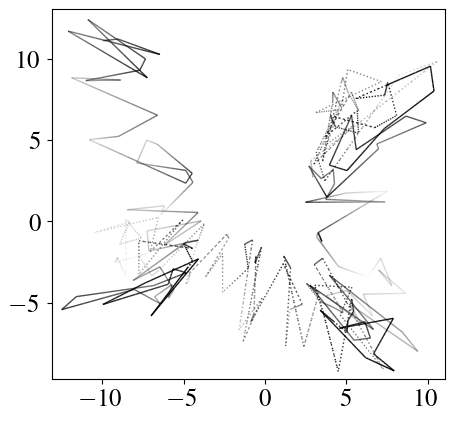

In [5]:
bin_r = chrom_pdb[['x', 'y', 'z']].to_numpy() # [~chrom_pdb.index.isin(list(range(389,396)))]
# bin_r = bin_r[bin_r[:,1]>-7][:-1]
bin_r = bin_r[::-1]
bin_r = bin_r - np.mean(bin_r, axis=0)
U, S, Vt = np.linalg.svd(bin_r)
bin_r = bin_r @ Vt.T
bin_r *= 15 / 1.2 / np.max(np.abs(bin_r))
fig, ax = plt.subplots()
plot_curve_with_opacity(ax, bin_r, z_plane=0, num_segments=10, global_max=0, visibility=0.95)
ax.set_xlim(np.min(bin_r[:, 0])*1.05, np.max(bin_r[:, 0])*1.05)
ax.set_ylim(np.min(bin_r[:, 1])*1.05, np.max(bin_r[:, 1])*1.05)
ax.set_aspect('equal', adjustable='box')

In [6]:
dist = norm(bin_r[1:]-bin_r[:-1], axis=1)
u_c = np.r_[0, np.cumsum(dist**0.5)]
spl = make_interp_spline(u_c, bin_r, axis=0)
uu = np.linspace(u_c[0], u_c[-1], len(dist)*10)
bin_r_spline = spl(uu)

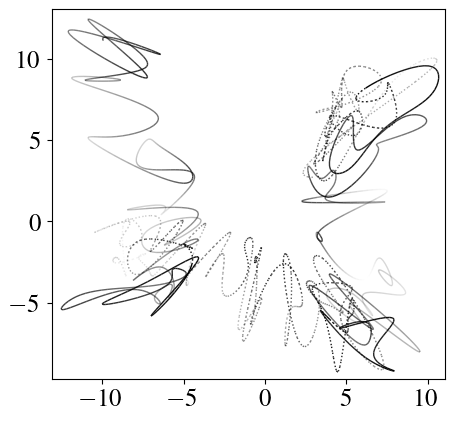

In [7]:
fig, ax = plt.subplots()
plot_curve_with_opacity(ax, bin_r_spline, z_plane=0, num_segments=1, global_max=0, visibility=0.95)
ax.set_xlim(np.min(bin_r[:, 0])*1.05, np.max(bin_r[:, 0])*1.05)
ax.set_ylim(np.min(bin_r[:, 1])*1.05, np.max(bin_r[:, 1])*1.05)
ax.set_aspect('equal', adjustable='box')

Text(0.5, 1.0, '$\\frac{angle}{\\pi}$ for adjacent interbin vectors')

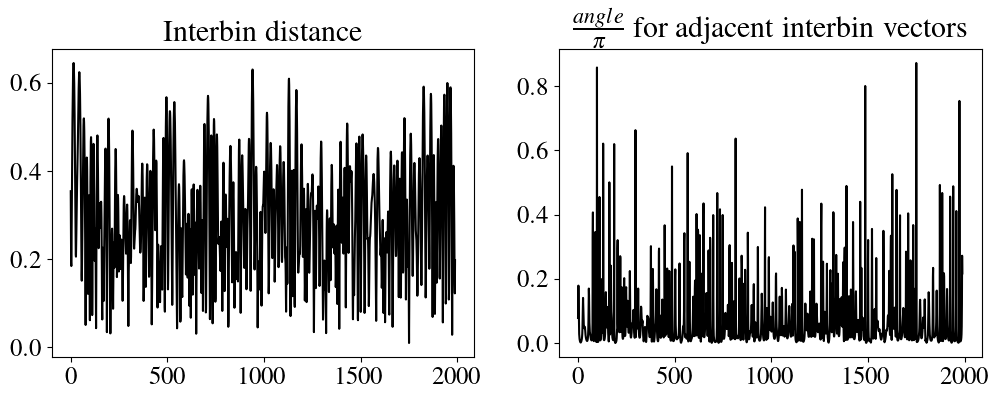

In [8]:
dist_r = bin_r_spline[1:]-bin_r_spline[:-1]
dist = norm(dist_r, axis=1)
cos_ = (dist_r[:-1] * dist_r[1:]).sum(1) / dist[:-1] / dist[1:]
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(dist, c='black')
ax[0].set_title('Interbin distance')
ax[1].plot(np.arccos(cos_) / np.pi, c='black')
ax[1].set_title(r'$\frac{angle}{\pi}$ for adjacent interbin vectors')

# fig.savefig(fname=f'{out_f}_geom.svg', bbox_inches='tight', format='svg')
# fig.savefig(fname=f'{out_f}_geom.png', bbox_inches='tight', dpi=300, format='png')

In [9]:
min_size, scale, sigma = 0.1, 5, 0.5
mesh_f = f'{path}/results/GSM5851256_MCF7_Rep1_bin_50Kb_chr11_60Mb_70Mb_sparse/mesh_min_size_{min_size}_scale_{scale}_sigma_chr_{sigma}.msh2'

In [46]:
timeit.timeit(lambda: chrom_3d_sparse(bin_r_spline, min_size, scale, sigma, mesh_f, space_scale=1.2), number=1)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [  0%] Meshing curve 3 (Line)
Info    : [  0%] Meshing curve 2 (Line)
Info    : [  0%] Meshing curve 5 (Line)
Info    : [  0%] Meshing curve 8 (Line)
Info    : [  0%] Meshing curve 4 (Line)
Info    : [  0%] Meshing curve 9 (Line)
Info    : [  0%] Meshing curve 10 (Line)
Info    : [  0%] Meshing curve 14 (Line)
Info    : [  0%] Meshing curve 12 (Line)
Info    : [  0%] Meshing curve 15 (Line)
Info    : [  0%] Meshing curve 6 (Line)
Info    : [  0%] Meshing curve 13 (Line)
Info    : [  0%] Meshing curve 7 (Line)
Info    : [  0%] Meshing curve 16 (Line)
Info    : [  0%] Meshing curve 11 (Line)
Info    : [  0%] Meshing curve 17 (Line)
Info    : [  0%] Meshing curve 18 (Line)
Info    : [  0%] Meshing curve 19 (Line)
Info    : [  0%] Meshing curve 20 (Line)
Info    : [  0%] Meshing curve 21 (Line)
Info    : [  0%] Meshing curve 22 (Line)
Info    : [  0%] Meshing curve 23 (Line)
Info    : [  0%] Meshing curve 24 (Line)
I

Info    : Done writing '/home/artem.kays/scripts/lncRNAeffects/RNA_diffusion/results/GSM5851256_MCF7_Rep1_bin_50Kb_chr11_60Mb_70Mb_sparse/mesh_min_size_0.1_scale_5_sigma_chr_0.5.msh2'


3.7636375967413187

In [58]:
gmsh.finalize()

In [48]:
mesh = fp.Gmsh3D(mesh_f)
mesh.cellCenters.shape

(3, 78998)

In [64]:
input_parameters = input_parse('input/input_params_diffusion.txt')
dim = input_parameters['dimension']
chrom_f = input_parameters['chrom_f']
chrom_size = input_parameters['chrom_size']
space_scale=input_parameters['space_scale']
min_size = input_parameters['min_size']
scale = input_parameters['scale']
sigma_chr = input_parameters['sigma_chr']

In [14]:
ext_faces=mesh.faceCenters.value.T[mesh.exteriorFaces]
chr_faces=KDTree(ext_faces[KDTree(bin_r_spline).query(ext_faces)[0] < space_scale*(sigma**2 + max(dist)**2)**0.5])
d_chr = fp.CellVariable(mesh=mesh, name=r'$d_{chr}$', value = chr_faces.query(mesh.cellCenters.value.T)[0] + sigma_chr)

In [50]:
d_chr = fp.CellVariable(mesh=mesh, name=r'$d_{chr}$', value = dist_to_polygonal_chain_knn(mesh.cellCenters.value.T, bin_r_spline, 20))

In [51]:
def mesh_triang(mesh, mask_z, bin_r, sigma_chr, mode_cells=1):
    if mode_cells:
        triang = tri.Triangulation(mesh.x.value[mask_z], mesh.y.value[mask_z])
        # mask_b_1 = np.all(np.any(mesh.exteriorFaces.value[mesh.cellFaceIDs.data[:, mask_z]], axis=0)[triang.triangles], axis=1)
        # mask_b_2 = (KDTree(bin_r).query(np.mean(mesh.cellCenters.value[:,mask_z].T[triang.triangles], axis=1))[0]<sigma_chr)
        # triang.set_mask(mask_b_1 | mask_b_2)
    else:
        triang = tri.Triangulation(mesh.faceCenters.value[0], mesh.faceCenters.value[1])
        triang.set_mask(np.all(mesh.exteriorFaces.value[triang.triangles], axis=1))

    return triang

In [66]:
out_f = f'{path}/figures/sandbox/GSM5851256_MCF7_Rep1_bin_50Kb_chr11_60Mb_70Mb'
rna_nucleus_location = bin_r[::-1][int(input_parameters['lncRNA_gene_bin'])]
plane_pos, thres = 0.5, min_size / 2
plane_pos = (rna_nucleus_location[2] - mesh.z.value.min()) / (mesh.z.value.max() - mesh.z.value.min())
plane = mesh.z.value.min() + plane_pos * (mesh.z.value.max() - mesh.z.value.min())
mask_z = (abs(mesh.z.value - plane) < thres * (1 + 10*(d_chr/d_chr.max())**2))

In [56]:
rna_nucleus_location

array([ 4.62761811, -5.74982374, -3.18236697])

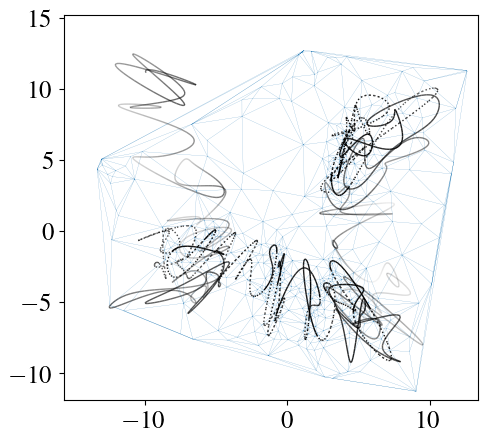

In [67]:
triang = mesh_triang(mesh, mask_z, bin_r_spline, sigma, mode_cells=1)

fig, ax = plt.subplots(figsize=(8,5))
ax.triplot(triang, lw=0.1)
plot_curve_with_opacity(ax, bin_r_spline, z_plane=plane, num_segments=1, global_max=0, visibility=1)
# plt.scatter(bin_r[:, 0], bin_r[:, 1], s=5, c='black')

ax.set_xlim(np.min(mesh.x.value)*1.05, np.max(mesh.x.value)*1.05)
ax.set_ylim(np.min(mesh.y.value)*1.05, np.max(mesh.y.value)*1.05)
ax.set_aspect('equal', adjustable='box')
fig.savefig(fname=f'{out_f}_mesh_sparse.png', dpi=300, format='png')

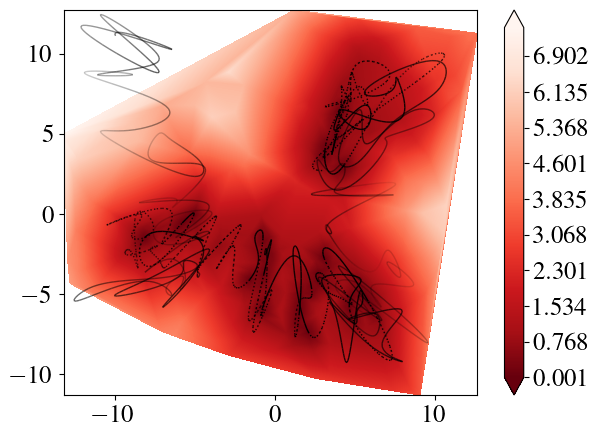

In [26]:
fig, ax = plt.subplots(figsize=(7,5))
# plt.title(f'{name} equilibrium distribution')
cs = ax.tricontourf(triang,
                    d_chr[mask_z],
                    levels=np.linspace(d_chr.min(), d_chr.max(), 256),
                    cmap="Reds_r",
                    extend="both")
plot_curve_with_opacity(ax, bin_r_spline, z_plane=plane, num_segments=1, global_max=0, visibility=1)
cbar=fig.colorbar(cs, ax=ax)
cbar.formatter.set_powerlimits((0, 0))
ax.set_aspect('equal', adjustable='box')

In [27]:
k_p_max = input_parameters['k_p_max_lncRNA']
k_p_x = input_parameters['k_p_max_lncRNA']*fp.CellVariable(mesh = mesh, name=r'$k_p(x)$', value = np.exp(-((rna_nucleus_location[0]-mesh.cellCenters[0])**2 + (rna_nucleus_location[1]-mesh.cellCenters[1])**2 + (rna_nucleus_location[2]-mesh.cellCenters[2])**2 - sigma_chr**2)/(input_parameters['spread_kp_lncRNA']+sigma_chr)**2))
phi_p = fp.CellVariable(mesh=mesh, name=r'$\phi_{prot}$',
                        value = k_p_x)

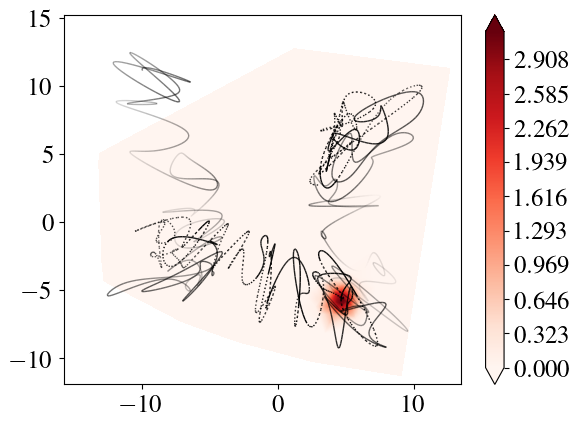

In [28]:
sp_var = phi_p

fig, ax = plt.subplots()
cs = ax.tricontourf(triang,
                    sp_var[mask_z],
                    levels=np.linspace(sp_var.min(), sp_var.max(), 256),
                    cmap="Reds",
                    extend="both")
fig.colorbar(cs)
plot_curve_with_opacity(ax, bin_r_spline, z_plane=plane, num_segments=1, global_max=0, visibility=0.95)

ax.set_xlim(np.min(mesh.x.value)*1.05, np.max(mesh.x.value)*1.05)
ax.set_ylim(np.min(mesh.y.value)*1.05, np.max(mesh.y.value)*1.05)
ax.set_aspect('equal', adjustable='box')
# fig.savefig(fname=f'{out_f}_phi_0.png', bbox_inches='tight', dpi=300, format='png')

In [29]:
eqn = (fp.TransientTerm(var=phi_p) == fp.DiffusionTerm(coeff=10, var=phi_p))
for i in range(60):
    eqn.sweep(dt=0.01)

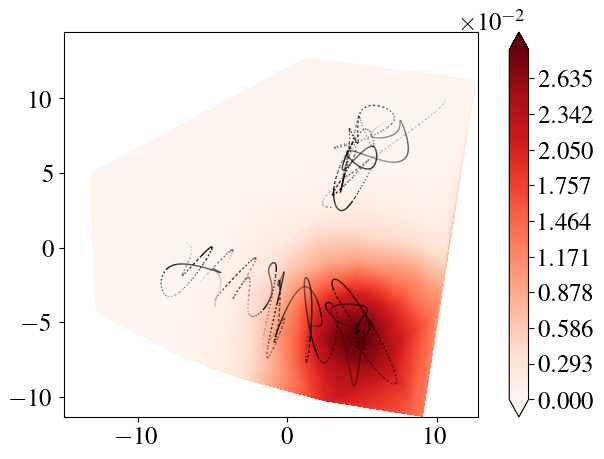

In [31]:
fig, ax = plt.subplots(figsize=(8,5))
cs = ax.tricontourf(triang,
                    phi_p[mask_z],
                    levels=np.linspace(0, phi_p[mask_z].max(), 256),
                    cmap="Reds",
                    extend="both")
cbar=fig.colorbar(cs)
cbar.formatter.set_powerlimits((0, 0))
plot_curve_with_opacity(ax, bin_r_spline, z_plane=plane, num_segments=1, global_max=1, visibility=0.2)

ax.set_xlim(np.min(mesh.x.value), np.max(mesh.x.value))
ax.set_ylim(np.min(mesh.y.value), np.max(mesh.y.value))
ax.set_aspect('equal', adjustable='box')
# fig.savefig(fname=f'{out_f}_phi.png', bbox_inches='tight', dpi=300, format='png')

In [195]:
z_scan(bin_r, f'{out_f}_phi', thres=5e-3, num_segments=10, global_max=1, visibility=0.2, nframes=201, fps=8, out_format='mp4')

201it [08:19,  2.48s/it]


Moviepy - Building video /home/artem.kays/scripts/lncRNAeffects/RNA_diffusion/figures/sandbox/GSE184270_GM12878_chr4_1000000_phi.mp4.
Moviepy - Writing video /home/artem.kays/scripts/lncRNAeffects/RNA_diffusion/figures/sandbox/GSE184270_GM12878_chr4_1000000_phi.mp4



Moviepy - Done !
Moviepy - video ready /home/artem.kays/scripts/lncRNAeffects/RNA_diffusion/figures/sandbox/GSE184270_GM12878_chr4_1000000_phi.mp4
